# LUCID Model

This the jupyter notebook that implements the LUCID CNN model to process the parsed network flow data to detect abnormal network traffic. There will be  sections in this notebook. Please run these sections in sequence to make sure the model can be run smoothly. 
* Environment Setup
* Data Loader
* Create Model
* Train Model

## Setup

### Import Packages

Import the packages required for this jupyter notebook

In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import s3fs
import h5py
import numpy as np
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

# check if GPU is available
cuda = torch.cuda.is_available()
cuda

False

### S3 Bucket

Connect to the S3 bucket that stores the train, validation and test dataset. Inspect the data stored there.

In [2]:
s3 = s3fs.S3FileSystem()

# check the folders in the s3 bucket
s3.ls("capstone-ddos-data")

['capstone-ddos-data/',
 'capstone-ddos-data/.',
 'capstone-ddos-data/best_model',
 'capstone-ddos-data/capstone-ddos-data',
 'capstone-ddos-data/capstone-ddos-data',
 'capstone-ddos-data/firstZipDataset',
 'capstone-ddos-data/model',
 'capstone-ddos-data/model',
 'capstone-ddos-data/model.bin',
 'capstone-ddos-data/model.json',
 'capstone-ddos-data/test,',
 'capstone-ddos-data/testEmptyFolder',
 'capstone-ddos-data/tryout',
 'capstone-ddos-data/tryout2']

In [3]:
# check the files in the dataset folder 
s3.ls("capstone-ddos-data/firstZipDataset")

['capstone-ddos-data/firstZipDataset/1000t-1000n-DDOS2019-dataset-test.hdf5',
 'capstone-ddos-data/firstZipDataset/1000t-1000n-DDOS2019-dataset-train.hdf5',
 'capstone-ddos-data/firstZipDataset/1000t-1000n-DDOS2019-dataset-val.hdf5',
 'capstone-ddos-data/firstZipDataset/1000t-1000n-DDOS2019-preprocess.data',
 'capstone-ddos-data/firstZipDataset/10t-100n-DDOS2019-dataset-test.hdf5',
 'capstone-ddos-data/firstZipDataset/10t-100n-DDOS2019-dataset-train.hdf5',
 'capstone-ddos-data/firstZipDataset/10t-100n-DDOS2019-dataset-val.hdf5',
 'capstone-ddos-data/firstZipDataset/10t-100n-DDOS2019-preprocess.data',
 'capstone-ddos-data/firstZipDataset/10t-10n-DDOS2019-dataset-test.hdf5',
 'capstone-ddos-data/firstZipDataset/10t-10n-DDOS2019-dataset-train.hdf5',
 'capstone-ddos-data/firstZipDataset/10t-10n-DDOS2019-dataset-val.hdf5',
 'capstone-ddos-data/firstZipDataset/10t-10n-DDOS2019-preprocess.data',
 'capstone-ddos-data/firstZipDataset/history.log']

In [4]:
# inspect data
dataset = h5py.File(s3.open("s3://capstone-ddos-data/firstZipDataset/10t-10n-DDOS2019-dataset-train.hdf5", "rb"))
print(dataset['set_x'])
print(dataset['set_y'])

<HDF5 dataset "set_x": shape (25083, 10, 11), type "<f8">
<HDF5 dataset "set_y": shape (25083,), type "<i8">


In [5]:
# s3 = boto3.client('s3')
# bucket_name = "capstone-ddos-data"
# directory_name = "test," #it's name of your folders
# s3.put_object(Bucket=bucket_name, Key=(directory_name+'/'))

### SageMaker

Set up the SageMaker local file directory to store the model checkpoints before uploading to S3 bucket. Ignore this command if the model directory is already exists. It will show an error message of "mkdir: cannot create directory ‘model’: File exists"

In [6]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [7]:
model_path = "/home/ec2-user/SageMaker/model/"

## Data Loader

Load the dataset with the specified t and n values. t and n are spcified at the data processing stage where they will determine how the data need to be parsed. t is the time window that we capture all the packets from the file. Thus, for the training data, it is the time window that we used to cut the data flow into different sections. n is the maximum number of packets the parsing process collects for each flow within the time window t.

In [8]:
# specify the t and n parameters to load the corresponding data
t = 10
n = 10

In [9]:
train_file = "s3://capstone-ddos-data/firstZipDataset/"+str(t)+"t-"+str(n)+"n-DDOS2019-dataset-train.hdf5"
val_file = "s3://capstone-ddos-data/firstZipDataset/"+str(t)+"t-"+str(n)+"n-DDOS2019-dataset-val.hdf5"

In [10]:
# load training and dev data
dataset = h5py.File(s3.open(train_file, 'rb'))
train_data = np.array(dataset['set_x'][:])
train_labels = np.array(dataset["set_y"][:])

dataset_val = h5py.File(s3.open(val_file, 'rb'))
val_data = np.array(dataset_val['set_x'][:])
val_labels = np.array(dataset_val["set_y"][:])

In [11]:
# check the data shape
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)

(25083, 10, 11)
(25083,)
(2787, 10, 11)
(2787,)


In [12]:
# check whether the data is balanced
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 12672, 1: 12411}

### Customization

This is the class that used to convert the data into correct shape and format and input into the pytorch model.

In [13]:
# Define dataset class
class MyDataSet(Dataset):
    # load the dataset
    def __init__(self, x, y):
        self.X = x
        self.Y = y

    # get number of items/rows in dataset
    def __len__(self):
        return len(self.Y)

    # get row item at some index
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def collate_fn(batch):
        batch_y = [y for x, y in batch]
        batch_x = [x for x, y in batch]

        batch_x = torch.as_tensor(batch_x).float()
        batch_y = torch.as_tensor(batch_y).float()

        return batch_x, batch_y.reshape(-1,1)


### Load Data

Load the data to train_loader and val_loader to be sent to the training process in the next session

In [14]:
# hyperparameters used to load the dataset.
batch_size = 20
num_workers = 6 if cuda else 0

**Shuffle need to be true for training and false for validation**

Shuffling the training data set makes sure that every epoch of training will see different subset of training data. This will help to speed up training process and avoid the model to just remember the output order to cause overfitting. 

The sequence of packets is preseved within the time t. Thus, if we think sequence of packets is important, we can increase t to emphasize on that feature. We tried t = 10, 50, 100 and 150 and observe that t=100 is the best hyperparameter.


In [15]:
# training data
train = MyDataSet(train_data, train_labels)
train_args = dict(shuffle = True, batch_size = batch_size, num_workers=num_workers, pin_memory=True, collate_fn=MyDataSet.collate_fn) if cuda else dict(shuffle=True, batch_size=1024, collate_fn=MyDataSet.collate_fn)
train_loader = DataLoader(train, **train_args)

In [16]:
# validation data
dev = MyDataSet(val_data, val_labels)
dev_args = dict(shuffle=False, batch_size=batch_size, num_workers=num_workers, pin_memory=True, collate_fn=MyDataSet.collate_fn) if cuda else dict(shuffle=False, batch_size=64, collate_fn=MyDataSet.collate_fn)
val_loader = DataLoader(dev, **dev_args)

## Create Model

### Model Hyperparameters

Model hyperparameters that could be tuned to optimize the performance of the model. The current values are optimized based on the paper suggestions and experiments.

In [17]:
k = 64
h = 3
cnn_dropout = 0
m = 98
if m > n:
    maxpool_kernel_size = n
else:
    maxpool_kernel_size = m

# in_features number for linear layer
in_feature_no = ((n - maxpool_kernel_size) + 1) * k

### Model Architecture

Model architecture suggested by the paper. The print statements could be used to debug the model structure.

In [25]:
class model(nn.Module):
    def __init__(self, input_size, output_size):
        super(model, self).__init__()

        # CNN Layer
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=k, kernel_size=h, stride=1, padding=1)
        self.cnndrop = nn.Dropout(p=cnn_dropout)
        self.relu = nn.ReLU()

        # Maxpooling Layer
        self.maxpool = nn.MaxPool1d(kernel_size=maxpool_kernel_size, stride = 1)

        # Flatten Layer
        self.flatten = nn.Flatten()

        # FC Layer
        self.linear = nn.Linear(in_features=in_feature_no, out_features=output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch_size, t=10, num_features) -> (batch_size, num_features, t=10)
        x = x.permute(0, 2, 1)
        # print("x: (batch_size, num_features, t=10)", x.shape)

        # --------- CNN Layer -----------
        x = self.conv(x)
        x = self.relu(x)
        # print("x: (batch_size, k, n-h+1", x.shape)

        # --------- Max Pooling Layer ----------
        x = self.maxpool(x)
        # print("x: (batch_size, k, ~512", x.shape)

        # --------- Flatten Layer -----------
        x = self.flatten(x)
        # print("x: batch_size, k*1", x.shape)

        # --------- Fully Connected Layer ---------
        x = self.linear(x)
        x = self.sigmoid(x)

        return x


### Model Input and Output

The input size of the model is the number of attributes decided by the data preprocessing stage. The current number is 11 where we extracted 11 attributes to train the model.

The output size of the model is 1 where we will output 0 or 1 to determine whether the parsed network flow is abnormal or normal flow.

In [26]:
in_feature = 11
output_size = 1

## Train Model

### Training Hyperparameters

Hyperparameters in the training process. Could be changed to improve the training speed and decide the early stop points.

In [27]:
lr = 0.01
scheduler_factor = 0.5
scheduler_patience = 2

### Training Setup

Setup the training variables such as loss function, optimizer and model before sending into the train function.

In [28]:
# model
model = model(in_feature, output_size)

# loss function
criterion = nn.BCELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=scheduler_factor, patience=scheduler_patience)

# GPU setup if GPU is available
device = torch.device("cuda" if cuda else "cpu")
model = model.to(device)
print(model)

model(
  (conv): Conv1d(11, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (cnndrop): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=10, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Training Function

Training function that will be called below to train the model and backpropagate the loss to tune the parameter values using Adam optimizer specified in the previous section.

In [29]:
def train(train_loader, model, criterion, optimizer, device, scheduler):
    model.train()
    running_loss = 0.0

    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        loss = criterion(output, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        # clean after usage to avoid memory overflow
        del data
        del target
        del output
        del loss

    end_time = time.time()
    running_loss /= len(train_loader)
    print("Training Loss: ", running_loss, "Time: ", (end_time - start_time)/60, 'mins')
    return running_loss

### Validation Function

#### Classification Breaking Point
This is the threshold that we used to determin whether the network flow is abnormal or normal. If the predicted probability of the model is bigger than the threshold, we will classify the network flow to be 1, abnormal. If the predicted proability is smaller than the threshold, we will classfiy the network flow to be 0, normal.

In [30]:
# threshold to determine abnormal and normal communication
p = 0.5

Validation function that will be called below during training to evaluate the model. The model will not be trained on the validation set. But it will be evaluated on this dataset to prevent overfitting of the model on the training dataset. Once the error of model on the validation set start to increase, we will stop the training process to prevent overfitting. The evaluation metrics we used includes:
* Accuracy
* F1 score

In [31]:
def validate(val_loader, model, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0
        correct_predictions = 0
        total_predictions = 0
        running_f1_score = 0

        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = criterion(output, target).detach()
            running_loss += loss.item()
            
            prediction = np.zeros(output.shape)
            prediction[output >= p] = 1
            y_true = target.detach().cpu().numpy()
            y_pred = prediction
            running_f1_score += f1_score(y_true, y_pred, average='weighted')


            correct_predictions += np.sum(y_true == y_pred)
            total_predictions += output.shape[0]
            
            # clean after usage to avoid memory overflow
            del data
            del target
            del output
            del loss

    
        running_loss /= len(val_loader)
        running_f1_score /= len(val_loader)
        acc = (correct_predictions/total_predictions) * 100.0
        print('Validation Loss: ', running_loss)
        print('Validation Accuracy: ', acc, "%")
        print('Validation F1 Score: ', running_f1_score)
    
    return running_loss, acc

### Run Function

This is the function that will be called to train the model on the complete training dataset for n_epochs specified below. The intermediate checkpoints will be saved locally onto the SageMaker before upload to the S3 bucket.

In [32]:
# number of times the training dataset will be used to train the model
n_epochs = 50

In [33]:
def run(n_epochs_range, model, criterion, optimizer, scheduler):
    TRAIN_LOSS = []
    VAL_LOSS = []
    VAL_ACC = []

    for i in n_epochs_range:
        print(i)
        # Train model
        start_time = time.time()
        train_loss = train(train_loader, model, criterion, optimizer, device, scheduler)
        end_time = time.time()
        TRAIN_LOSS.append(train_loss)
        
        # Validate model
        start_time = time.time()
        val_loss, val_acc = validate(val_loader, model, criterion)
        end_time = time.time()
        VAL_LOSS.append(val_loss)
        VAL_ACC.append(val_acc)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save the train model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, model_path + "Model_" + str(i))

        # Save the train log
        message = "Epoch: {}, training loss is {}, training time is {} minutes". format(i, train_loss, (end_time-start_time)/60.0)
        with open(model_path + 'performance.txt','a') as f:
            f.write(message +'\n')

        # Save the validation log
        message = 'Epcho: {}, validation loss is {}, validation accuracy is {}, validation time is {} minutes'.format(i,val_loss, val_acc, (end_time - start_time)/60.0)
        with open(model_path + 'performance.txt','a') as f:
            f.write(message +'\n')

    return TRAIN_LOSS, VAL_LOSS, VAL_ACC

### Start to Train

Start the training function. The training information such as training loss and validation loss will be printed while training the model.

In [34]:
# Run from the start
n_epochs_range = range(n_epochs)
train_error, val_error, val_accuracy = run(n_epochs_range, model, criterion, optimizer, scheduler)

0
Training Loss:  0.5830080211162567 Time:  0.03824814558029175 mins
Validation Loss:  0.45741205933419143
Validation Accuracy:  92.17796914244708 %
Validation F1 Score:  0.9213882899669261
1
Training Loss:  0.38944641828536986 Time:  0.01587134599685669 mins
Validation Loss:  0.31652027571743185
Validation Accuracy:  92.070326515967 %
Validation F1 Score:  0.9203300037226416
2
Training Loss:  0.27688460230827333 Time:  0.01566934585571289 mins
Validation Loss:  0.21559498526833273
Validation Accuracy:  91.81916038751345 %
Validation F1 Score:  0.9178759244818475
3
Training Loss:  0.20269007563591004 Time:  0.01598917245864868 mins
Validation Loss:  0.15915825658223845
Validation Accuracy:  91.89092213850017 %
Validation F1 Score:  0.9185893488306042
4
Training Loss:  0.15418796837329865 Time:  0.016069304943084717 mins
Validation Loss:  0.1213205572725697
Validation Accuracy:  94.86903480444923 %
Validation F1 Score:  0.9485493483663024
5
Training Loss:  0.12289514243602753 Time:  0.0

## Prediction

### Load Model

Load the best model saved previously.

In [35]:
parameters = torch.load('/home/ec2-user/SageMaker/model/Model_48')
model.load_state_dict(parameters['model_state_dict'])

# Use GPU if available
device = torch.device("cuda" if cuda else "cpu")
model.to(device)

model(
  (conv): Conv1d(11, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (cnndrop): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=10, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Load Data

Load the preprocessed test data from the folder.

In [36]:
test_file = "s3://capstone-ddos-data/firstZipDataset/"+str(t)+"t-"+str(n)+"n-DDOS2019-dataset-test.hdf5"

dataset_test = h5py.File(s3.open(test_file, 'rb'))
test_data = np.array(dataset_test['set_x'][:])

# normally for test data, we do not have the label
# test_labels = np.array(dataset_test["set_y"][:])

Define the data loader for test set where the lable y is not available

In [37]:
# Define test dataset class
class MyTestDataSet(Dataset):
    # load the dataset
    def __init__(self, x):
        self.X = x

    # get number of items/rows in dataset
    def __len__(self):
        return len(self.X)

    # get row item at some index
    def __getitem__(self, index):
        return self.X[index]

    def collate_fn(batch):
        batch_x = [x for x in batch]

        batch_x = torch.as_tensor(batch_x).float()

        return batch_x

Load the test data to test_loader that will be used for prediction function.

In [38]:
test = MyTestDataSet(test_data)
test_args = dict(shuffle=False, batch_size=batch_size, num_workers=num_workers, pin_memory=True, collate_fn=MyTestDataSet.collate_fn) if cuda else dict(shuffle=False, batch_size=64, collate_fn=MyTestDataSet.collate_fn)
test_loader = DataLoader(test, **test_args)

### Prediction Function

This is the prediction function that will produce the list of probabilities of the network flow belong to 0 or 1 class.

In [39]:
def predict(test_loader, model):
    predictions = np.array([])
    model.eval()
    with torch.no_grad():
        for x in test_loader:
            x = x.to(device).float()
            output = model(x)
            predictions = np.append(predictions, output)
            
    return predictions

In [40]:
probabilities = predict(test_loader, model)

Convert the probability predictions into class prediction using the threshold p defined previously.

In [41]:
prediction = np.zeros(probabilities.shape)
prediction[probabilities > p] = 1
prediction

array([1., 1., 0., ..., 0., 1., 1.])

### Check Model Performance

Compare the prediction of the model with the truth of the test dataset to see the performance of the model. Evaluate the model performance using the following metrics:
* Accuracy
* F1 Score
* Confusion Matrix

In [42]:
truth = np.array(dataset_test["set_y"][:])

In [43]:
print("Accuracy: ")
print(accuracy_score(truth, prediction))
print("F1 Score: ")
print(f1_score(truth, prediction, average='weighted'))
print("Confusion Matrix: ")
print(confusion_matrix(truth, prediction))

Accuracy: 
0.9983860555196902
F1 Score: 
0.9983859547115135
Confusion Matrix: 
[[1447    4]
 [   1 1646]]


### Plot ROC Curve

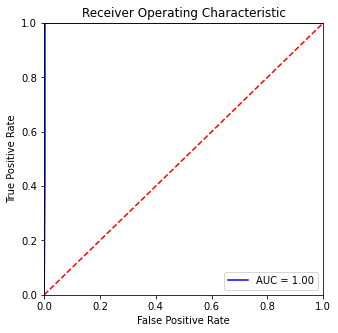

In [44]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(truth, probabilities)
roc_auc = metrics.auc(fpr, tpr)
plt.rcParams['figure.figsize'] = [5, 5]

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Visualize Filters

In this section, we would like to visualize the parameter values of the k filters learned by the model.

We hope to use this visualization to discover the types of features that the kernel focuse on detecting. The activation maps output by convolutional layers can be inspected to understand exactly what features were detected for the given input.

The graphs below shows the k filters in the cnn layer. The vertical 11 indices correspond to the 11 attributes of the input. The lighter the color, the higher the weights of the filter. The darker the color, the lower the weights of the filter. The 11 attributes are:

* 0: Time
* 1: Packet Len
* 2: Highest Layer
* 3: IP Flags
* 4: Protocols
* 5: TCP Lens
* 6: TCP Ack
* 7: TCP Flags
* 8: TCP Window Size
* 9: UDP Len
* 10: ICMP Type

In [45]:
from matplotlib import pyplot

In [46]:
filters = model.conv.weight.detach().numpy()
print(filters.shape)
biases = model.conv.bias.detach().numpy()
print(biases.shape)

(64, 11, 3)
(64,)


In [47]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

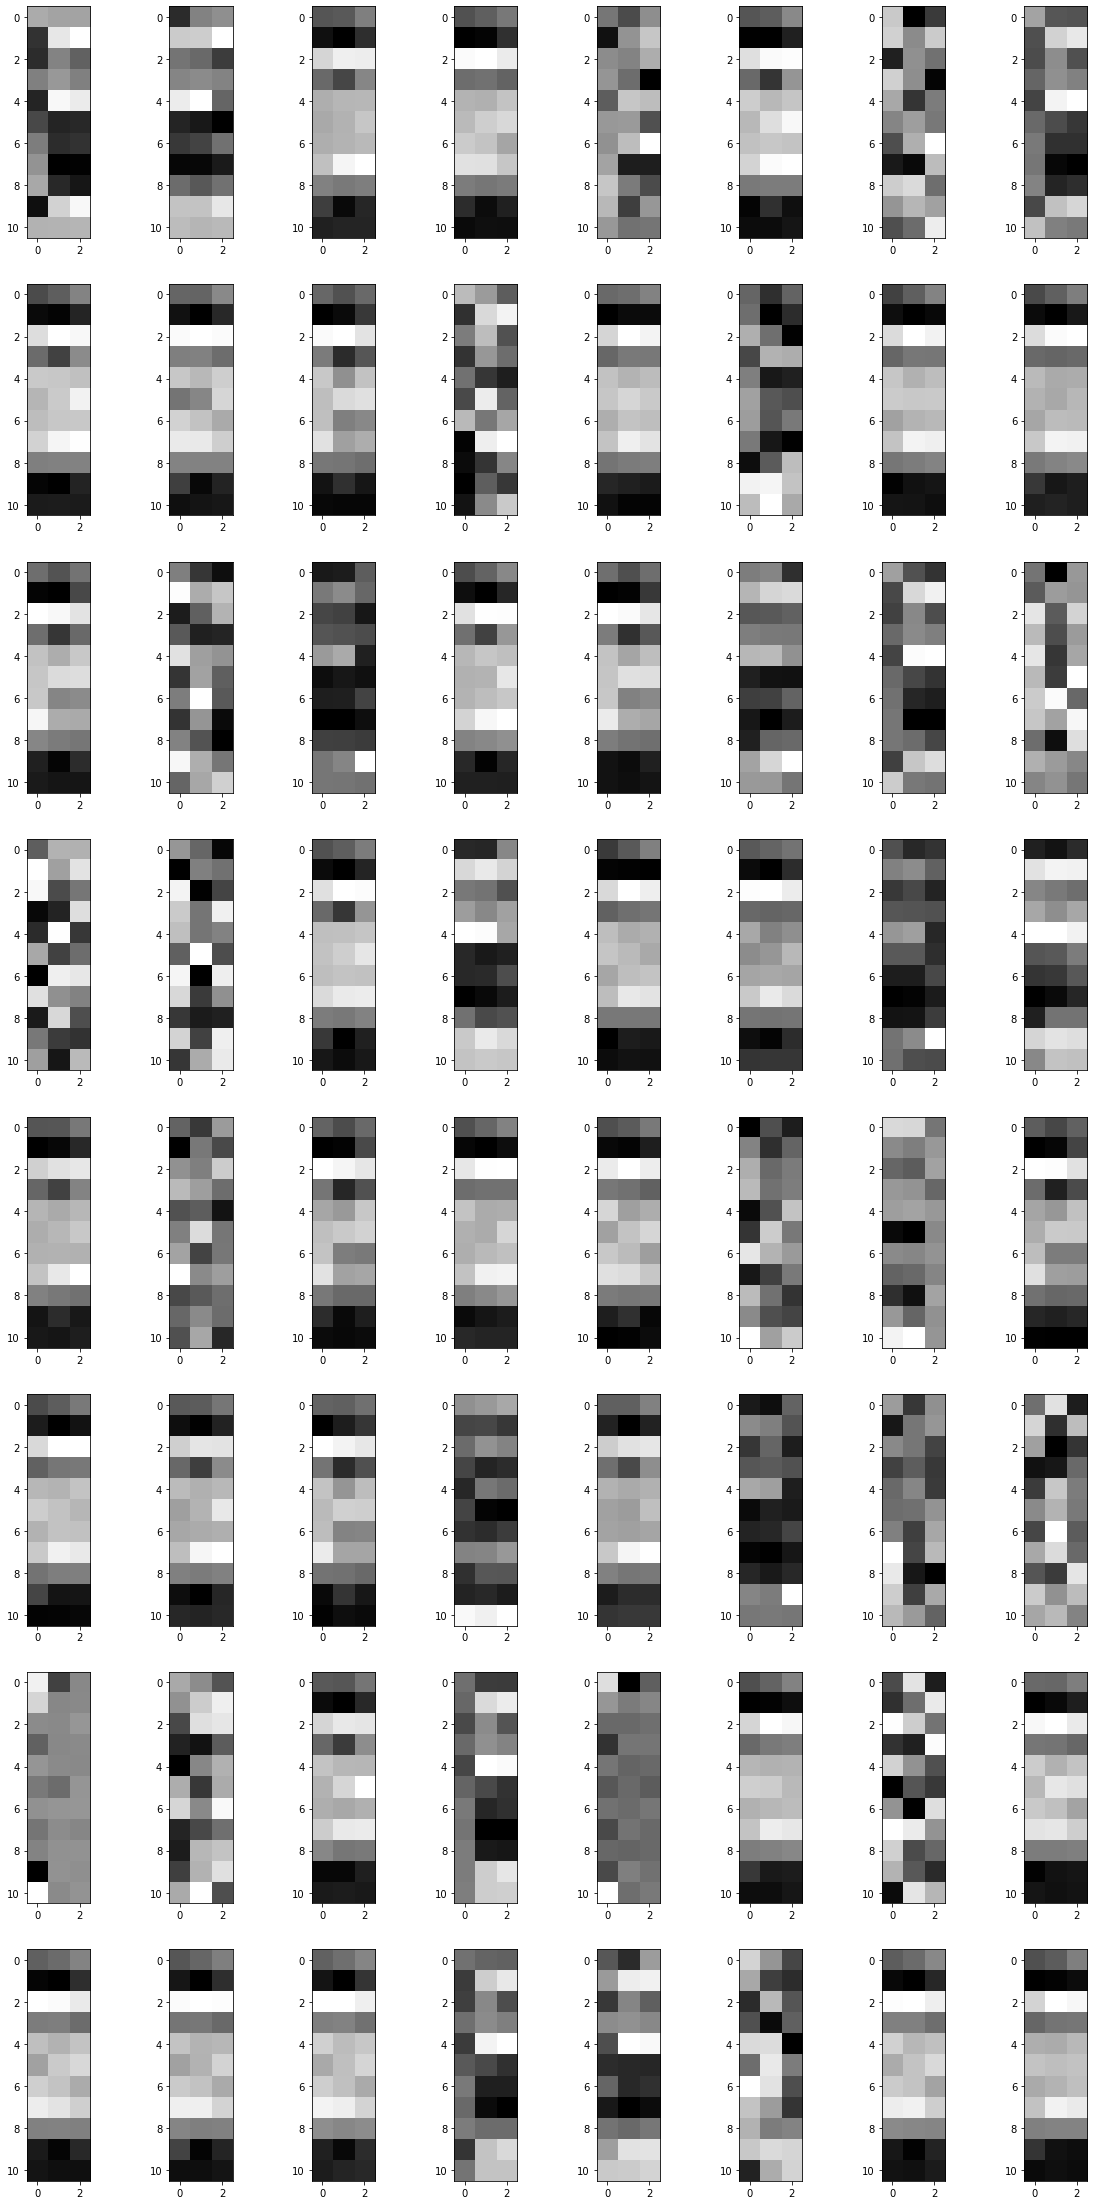

In [48]:
plt.rcParams['figure.figsize'] = [20, 40]
for i in range(k):
    # get the filter
    f = filters[i,:,:]
    plt.subplot(8,8,i+1)
    pyplot.imshow(f, cmap='gray')